# Smart Devices
In this simulation we model the interaction of smart devices with a physical network. More specifically we assume that we have a device (fridge) that is installed in a house and can react to a situation in the distribution grid. We model our physical network with a very simple resistor network. This gives us the advantage of only needing very simple math to calculate the physical state but of course lacks some of the complexity compared to the real world. 

The model works as follows:
    
    +----|U_s|---<R_i>------+
    |                       |
    |     /                 |
    |   +-o o-<R_fridge>-+  |
    |   |                |  |
    +---+                +--+  1
    |   |                |  |
    |   +------<R_const>-+  |
    |                       |
    |     /                 |
    |   +-o o-<R_fridge>-+  |
    |   |                |  |
    +---+                +--+  2
    |   |                |  |
    |   +------<R_const>-+  |
    |                       |
    |     /                 |
    |   +-o o-<R_fridge>-+  |
    |   |                |  |
    +---+                +--+  3
    |   |                |  |
    |   +------<R_const>-+  |
    .           .           .
    .           .           .
    .           .           .
    |                       |
    |     /                 |
    |   +-o o-<R_fridge>-+  |
    |   |                |  |
    +---+                +--+  n
    |   |                |  |
    |   +------<R_const>-+  |
    |                       |
    |       /               |
    +-------o o-<R_ext>-----+                

We have *n* houses with one fridge represented by *R_fridge* and some residual load represented by *R_const*. All a connected to a constant voltage source *U_s* which is in series with a resistor *R_i*. The quantity that we want to control is the voltage at the houses. This voltage is equal for all houses and depends on the overall load of the network. If to much load is connected the voltage drops and vice versa if too little load is connected it rises. This is comparable to the frequency and the voltage in the real power grid. (However in order to simulate a real power grid we would have to solve a differential equation system for each time step). Finally there is another resistor in the network, *R_ext*. It represents some external shock that will occour at some point in time during the simulaiton, reducing the voltage for all houses for some time.

The task of a smart fridge is now to react to a change in the voltage by either going on or off to reduce or increase the load on the network. However each fridge also has its own internal cycle to follow, it will change its state according to some cycle time *T* which is randomly distributed. Cycles can be broken in order to support the network. Each fridge acts individually and knows the following things:
    * idx - the index of the house
    * state - if it is on or off
    * t_state - how far it the cycle it is
    * T - how long each cycle is
    * U - the voltage of the bus
Note that we do not simulate an internal temperature of the fridge or anything comparable, for the sake of simplicity. 



In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pylab as plt
import ipywidgets as widgets
from IPython.display import display
from functools import partial

# Main Simulation

In [11]:
Uup = 5.1
Udown = 4.9

def simulate(fridge,t_end = 1000,t_ext_on = 500,t_ext_off = 600,speed = 0.5):

    size = 1000
    
    Us = 10 # V
    Ri = 1 # Ohm
    Rfridge = 2000 * np.ones(size) # Ohm
    Rconst = 1340 # Ohm
    Rext = 15 - np.random.rand()*5  # Ohm
    ext_onoff = 0

    Tfridge = 10*60+np.round((np.random.rand(1000)-0.5)*5*60)
    t_fridge = np.zeros(size)

    Fonoff = np.random.rand(size)>0.5 #np.ones(size,dtype=bool)*0
    Uhouse = np.zeros(t_end)
    Rsum = np.zeros(t_end)
    Isum = np.zeros(t_end)
    
    Fmatrix = np.empty((t_end,size))

    for t in range(t_end):


    #    if t>10 and t<50:
    #        Fonoff = np.zeros(size,dtype=bool)
    #    if t>50 and t<100:
    #        Fonoff = np.ones(size,dtype=bool)


        R = 1/(np.sum(1/Rfridge[Fonoff==1]) + size/Rconst + 1/Rext*ext_onoff) + Ri
        Rsum[t] = R
        I = Us / R
        Isum[t] = I
        Uhouse[t] = Us - I*Ri

        if (ext_onoff < 1) and (t_ext_off > t > t_ext_on):
            ext_onoff = min(1,ext_onoff+speed)
        if t > t_ext_off and ext_onoff >= 0:
            ext_onoff = max(0,ext_onoff-speed)

        for idx in range(size):
            
            state,t_state=fridge(idx,Fonoff[idx],t_fridge[idx],Tfridge[idx],Uhouse[t])
            Fonoff[idx] = state
            t_fridge[idx] = t_state
        
        
        
        if t > 60: 
            if np.mean(Uhouse[t-60:t]) > 5:
                Us -= 0.0001
            if np.mean(Uhouse[t-60:t]) < 5:
                Us += 0.0001
        
        Fmatrix[t,:] = Fonoff

    return Uhouse,Rsum,Isum,Fmatrix

# Normal Fridge

In [12]:
def fridge0(idx,state,t_state,T,U):
    t_state+=1
    if t_state > T:
        state = not state
        t_state = 0 + np.random.randint(10)
    return state,t_state

# Fridge 1

In [13]:
def fridge1(idx,state,t_state,T,U):
    if U > Uup:
        if state:
            return True,t_state
        else:
            return True,t_state
    elif U < Udown:
        if state:
            return False, t_state
        else:
            return False,t_state
    return fridge0(idx,state,t_state,T,U)

# Fridge 2

In [14]:
def fridge2(idx,state,t_state,T,U,threshold=0.5):
    if U > Uup and np.random.rand()>threshold:
        if state:
            return True,t_state
        else:
            return True,t_state
    elif U < Udown and np.random.rand()>threshold:
        if state:
            return False, t_state
        else:
            return False,t_state
    return fridge0(idx,state,t_state,T,U)

# Fridge 3

In [15]:
def fridge3(idx,state,t_state,T,U,scale):
    if U > Uup:
        if t_state == T:
            if state:
                return True,0
            else:
                return True,0
        else:
            t_state = T - np.round(np.random.exponential(scale))
    elif U < Udown:
        if t_state == T:
            if state:
                return False,0
            else:
                return False,0
        else:
            t_state = T - np.round(np.random.exponential(scale))
    return fridge0(idx,state,t_state,T,U)

# Fridge 4

In [16]:
def fridge4(idx,state,t_state,T,U,scale):
    diff = U - 5
    
    if diff > 0.05:
        if np.random.rand() < diff / scale:
            if state:
                return True,0
            else:
                return True,0
    elif diff < -0.05:
        if np.random.rand() < diff / -scale:
            if state:
                return False,0
            else:
                return False,0
    return fridge0(idx,state,t_state,T,U)

# UI
Here you can configure the simulation

In [17]:
Cfridge0 = widgets.Checkbox(value=True,description='include',disabled=False)
Cfridge1 = widgets.Checkbox(value=False,description='include',disabled=False)
Cfridge2 = widgets.Checkbox(value=False,description='include',disabled=False)
Sfridge2 = widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.001,description='threshold',readout=True,readout_format='.3f')
Cfridge3 = widgets.Checkbox(value=False,description='include',disabled=False)
Sfridge3 = widgets.IntSlider(value=20,min=0,max=200,step=1,description='scale',readout=True)
Cfridge4 = widgets.Checkbox(value=False,description='include',disabled=False)
Sfridge4 = widgets.FloatSlider(value=1,min=0,max=5,step=0.01,description='scale',readout=True)

Tsim = widgets.BoundedIntText(value=5000,max=100000,step=1,description='t:',disabled=False)
ONsim = widgets.BoundedIntText(value=1500,max=100000,step=1,description='t_on:',disabled=False)
OFFsim = widgets.BoundedIntText(value=2000,max=100000,step=1,description='t_off:',disabled=False)
SpeedSim = widgets.BoundedFloatText(value=0.5,min=0,max=1,description='speed:',disabled=False)
c = [widgets.VBox([Cfridge0]),
     widgets.VBox([Cfridge1]),
     widgets.VBox([Cfridge2,Sfridge2]),
     widgets.VBox([Cfridge3,Sfridge3]),
     widgets.VBox([Cfridge4,Sfridge4]),
     widgets.VBox([Tsim,ONsim,OFFsim,SpeedSim])]
accordion = widgets.Accordion(children=c)
accordion.set_title(0, 'Normal Fridge')
accordion.set_title(1, 'Smart Fridge 1')
accordion.set_title(2, 'Smart Fridge 2')
accordion.set_title(3, 'Smart Fridge 3')
accordion.set_title(4, 'Smart Fridge 4')
accordion.set_title(5, 'System')
accordion

Accordion(children=(VBox(children=(Checkbox(value=True, description='include'),)), VBox(children=(Checkbox(val…

# Simulate and show results
If you run the cell below the simulation will be run (takes some time) and two figures with results will be shown.

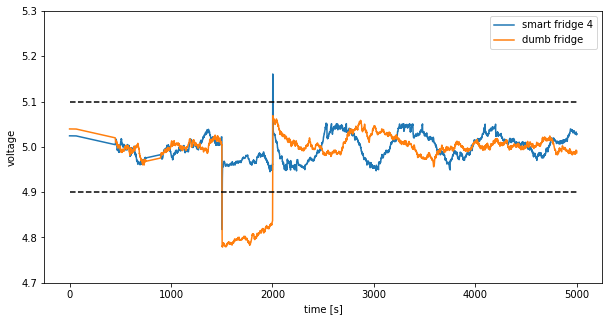

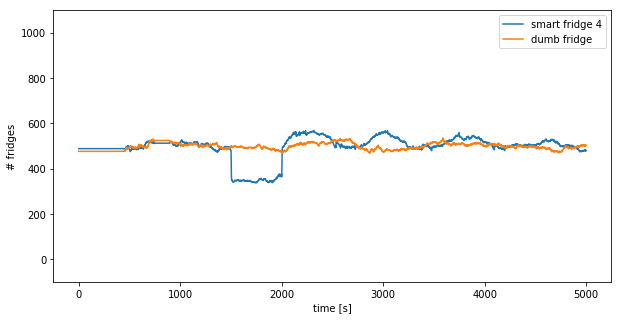

In [24]:
results = {}
t = Tsim.value
t_on = ONsim.value
t_off = OFFsim.value
speed = SpeedSim.value
if Cfridge0.value:
    Uhouse,Rsum,Isum,Fmatrix = simulate(fridge0,t,t_ext_on = t_on,t_ext_off=t_off,speed=speed)
    results['dumb fridge'] = (Uhouse,Rsum,Isum,Fmatrix)

if Cfridge1.value:
    Uhouse,Rsum,Isum,Fmatrix = simulate(fridge1,t,t_ext_on = t_on,t_ext_off=t_off,speed=speed)
    results['smart fridge 1'] = (Uhouse,Rsum,Isum,Fmatrix)

if Cfridge2.value:
    Uhouse,Rsum,Isum,Fmatrix = simulate(partial(fridge2,threshold=Sfridge2.value),t,t_ext_on = t_on,t_ext_off=t_off,speed=speed)
    results['smart fridge 2'] = (Uhouse,Rsum,Isum,Fmatrix)

if Cfridge3.value:
    Uhouse,Rsum,Isum,Fmatrix = simulate(partial(fridge3,scale=Sfridge3.value),t,t_ext_on = t_on,t_ext_off=t_off,speed=speed)
    results['smart fridge 3'] = (Uhouse,Rsum,Isum,Fmatrix)

if Cfridge4.value:
    Uhouse,Rsum,Isum,Fmatrix = simulate(partial(fridge4,scale=Sfridge4.value),t,t_ext_on = t_on,t_ext_off=t_off,speed=speed)
    results['smart fridge 4'] = (Uhouse,Rsum,Isum,Fmatrix)
    
plt.figure(figsize=(10,5))
for key,value in results.items():
    plt.plot(value[0],label=key)

plt.plot((0,t),(4.9,4.9),'--k')
plt.plot((0,t),(5.1,5.1),'--k')
plt.ylim((4.7,5.3))
plt.ylabel('voltage')
plt.xlabel('time [s]')
plt.legend()

plt.figure(figsize=(10,5))
for key,value in results.items():
    plt.plot(np.sum(value[3],axis=1),label=key)
plt.ylim((-100,1100))
plt.ylabel('# fridges')
plt.xlabel('time [s]')
plt.legend()


plt.show()